In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
import shapely.speedups
import pickle
import time
from shapely.geometry import Point
from matplotlib.ticker import PercentFormatter

%matplotlib inline
shapely.speedups.enable()

In [109]:
# Transform from EPSG:2236 to lat&lon
from osgeo import osr
inp= osr.SpatialReference()
inp.ImportFromEPSG(2263)
out= osr.SpatialReference()
out.ImportFromEPSG(4326)
transformation = osr.CoordinateTransformation(inp,out)
transformation_back = osr.CoordinateTransformation(out,inp)

In [9]:
zone_shp = gpd.read_file('data/taxi_zones/taxi_zones.shp') # downloaded from NYC Open Data
zone_lookup = pd.read_csv('data/taxi_zones/taxi_zone_lookup.csv') # downloaded from NYC Open Data

In [7]:
zone_shp.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
# Drop zones that are not on the island of Manhattan or entirely a park (128)
zone_lookup = zone_lookup[~zone_lookup['LocationID'].isin([103, 104, 105, 153, 194, 202])]

mh_zones = zone_lookup[zone_lookup['Borough']=='Manhattan']

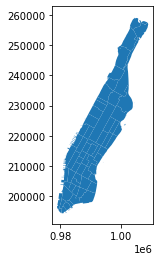

In [13]:
zone_shp = zone_shp[zone_shp['LocationID'].isin(mh_zones['LocationID'])]
zone_shp.plot()

In [18]:
zone_shp.loc[3]

OBJECTID                                                      4
Shape_Leng                                            0.0435665
Shape_Area                                          0.000111872
zone                                              Alphabet City
LocationID                                                    4
borough                                               Manhattan
geometry      POLYGON ((992073.4667968601 203714.0759887695,...
Name: 3, dtype: object

In [19]:
upper_manh_zones = [128, 127, 243, 244, 120, 116, 152, 42, 166, 41, 74, 24, 151, 238, 239, 143, 142, 43, 75, 236, 263, 262, 237, 141, 140]

In [25]:
lower_manh_zones = list(set(zone_shp['LocationID'].values.tolist()) - set(upper_manh_zones))

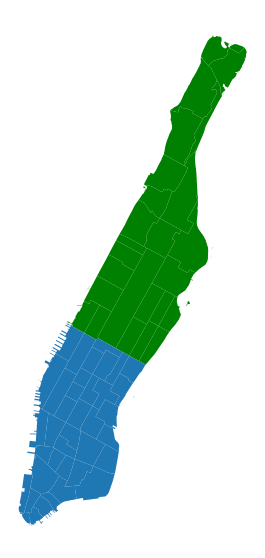

In [167]:
fig, ax = plt.subplots(figsize =(15,10))
zone_shp[zone_shp['LocationID'].isin(upper_manh_zones)].plot(ax=ax, color = 'green')
zone_shp[zone_shp['LocationID'].isin(lower_manh_zones)].plot(ax=ax)
plt.axis('off');

In [50]:
upper_zone_shp = zone_shp[zone_shp['LocationID'].isin(upper_manh_zones)]
lower_zone_shp = zone_shp[zone_shp['LocationID'].isin(lower_manh_zones)]

In [110]:
road_node = pd.read_csv("data/points.csv", header=None, names=['id', 'lat', 'lon'])

In [111]:
road_node.head()

,id,lat,lon
0,1,40.706991,-74.017946
1,2,40.706175,-74.017930
2,3,40.707914,-74.017808
3,4,40.706840,-74.017575
4,5,40.707624,-74.017503


In [112]:
# Create geometry points for road nodes
point_geometry = []
for i in road_node.index:
    lat = road_node.iloc[i]['lat']
    lon = road_node.iloc[i]['lon']
    x, y,_ = transformation_back.TransformPoint(lat, lon)
    s = Point(x, y)
    point_geometry.append(s)

In [113]:
road_node['geometry'] = point_geometry

In [114]:
road_node.head()

,id,lat,lon,geometry
0,1,40.706991,-74.017946,POINT (979274.4401066663 196852.8789666664)
1,2,40.706175,-74.017930,POINT (979278.8152825608 196555.5847442619)
2,3,40.707914,-74.017808,POINT (979312.7692106062 197189.1478250406)
3,4,40.706840,-74.017575,POINT (979377.2894666137 196797.8442728098)
4,5,40.707624,-74.017503,POINT (979397.3087108497 197083.4750530374)


In [115]:
zone_shp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
11,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20..."
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23..."
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23..."


In [117]:
road_node_dict = {}
for i in road_node.index:
    if i % int(len(road_node) /10) == 0:
        print(i)
    point_geometry = road_node.iloc[i]['geometry']
    road_id = road_node.iloc[i]['id']
    for j in zone_shp.index:
        zone_geometry = zone_shp.loc[j]['geometry']
        zone_id = zone_shp.loc[j]['LocationID']
        if zone_geometry.contains(point_geometry):
            if zone_id in upper_manh_zones:
                road_node_dict[road_id] = "upper"
            elif zone_id in lower_manh_zones:
                road_node_dict[road_id] = "lower"
            else:
                print(road_id)
            break

0
409
818
1227
1636
2045
2454
2863
3272
3681
4090


In [137]:
road_node_dict[2597] = 'lower' # Manully assign region to road node

In [138]:
set(list(range(4092))) - set(list(road_node_dict.keys()))

{0}

In [147]:
output_list = list(zip(list(road_node_dict.keys()), list(road_node_dict.values())))

In [153]:
pd.DataFrame(output_list).sort_values(by=0).to_csv('data/points_geo_split.csv', header=None, index=None)